# Stock Price Prediction with Stacked LSTM

In this project, I built a stock price forecasting model using a stacked LSTM architecture, trained on the past 100 days of closing prices to predict future values. The main goal was to explore the feasibility of using deep learning for time series forecasting, specifically applied to stock market data.

### ✅ Key Highlights:
- **Data Source:** Historical stock prices (CSV format)
- **Model Architecture:** Two-layer stacked LSTM with dropout regularization
- **Input:** Past 100 days of closing prices
- **Forecast Output:** Next 30 days (recursive forecasting)
- **Scaler Used:** StandardScaler for better generalization across varying price ranges


## 1. Data collection

In [2]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

In [11]:
df = yf.download('AAPL', start='2020-01-01', end='2025-04-30')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [18]:
df.columns = df.columns.get_level_values(0)

In [20]:
df.to_csv('AAPL.csv')

In [4]:
df=pd.read_csv('AAPL.csv')
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,72.716072,72.776598,71.466812,71.721019,135480400
1,2020-01-03,72.009117,72.771745,71.783962,71.941328,146322800
2,2020-01-06,72.582901,72.621639,70.876068,71.127858,118387200
3,2020-01-07,72.241554,72.849231,72.021238,72.592601,108872000
4,2020-01-08,73.403648,73.706279,71.943759,71.943759,132079200


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1338 non-null   object 
 1   Close   1338 non-null   float64
 2   High    1338 non-null   float64
 3   Low     1338 non-null   float64
 4   Open    1338 non-null   float64
 5   Volume  1338 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 62.8+ KB


In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Price')

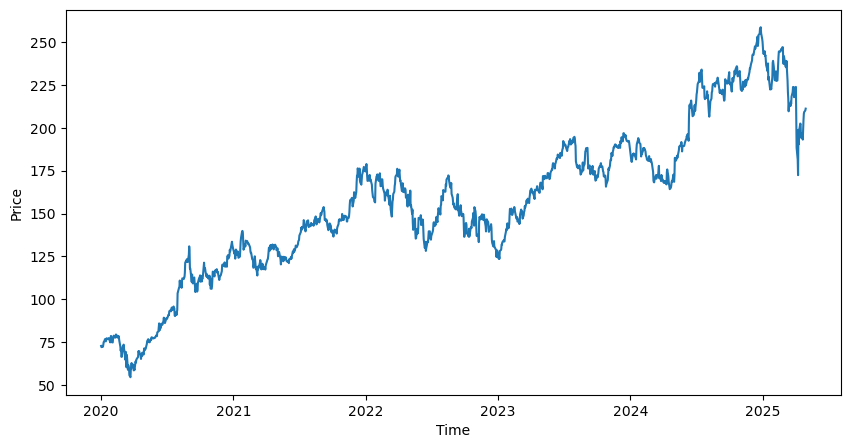

In [12]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Close'])
plt.xlabel('Time')
plt.ylabel('Price')

In [14]:
data = df[['Close']].values

In [14]:
data

array([[ 72.71607208],
       [ 72.00911713],
       [ 72.582901  ],
       ...,
       [209.27999878],
       [210.13999939],
       [211.21000671]])

## 2. Pre-process the Data

Instead of using MinMaxScaler, I chose to use StandardScaler because  stock prices don't have fixed bounds. The maximum or minimum in the training data may not apply in the future. That causes two potential issues:
1. Data Leakage (if improperly scaled)
   If we scale using the entire dataset (training + test), we are accidentally letting the model "see" future data — which is bad practice.
2. Extrapolation Risk
   When future prices go beyond the max/min of the training data, predictions may become unreliable after inverse transforming.

In [16]:
from sklearn.preprocessing import StandardScaler

In [18]:
# Initialize StandardScaler
scaler = StandardScaler()

In [20]:
# Fit only on training data to avoid leakage!
train_length = int(len(data) * 0.8)
scaled_data = np.concatenate((
    scaler.fit_transform(data[:train_length]),
    scaler.transform(data[train_length:])
))

In [24]:
# Create sequences of 100 time steps
X = []
y = []
sequence_length = 100

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

In [26]:
# Reshape for LSTM input (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [28]:
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 3. Create a Stacked LSTM Model

In [30]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout

In [32]:
model = Sequential()
model.add(Input(shape=(X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 0.1942 - val_loss: 0.6158
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0446 - val_loss: 0.2716
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0399 - val_loss: 0.2602
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0362 - val_loss: 0.1663
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0440 - val_loss: 0.3141
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0337 - val_loss: 0.1335
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0308 - val_loss: 0.1849
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0312 - val_loss: 0.0887
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0298 - val_loss: 0.0774
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0293 - val_loss: 0.0769
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0259 - val_loss: 0.1019
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/ste

## 4. Predict the Tes Data and Plot the Output

In [36]:
# Predict & inverse transform
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


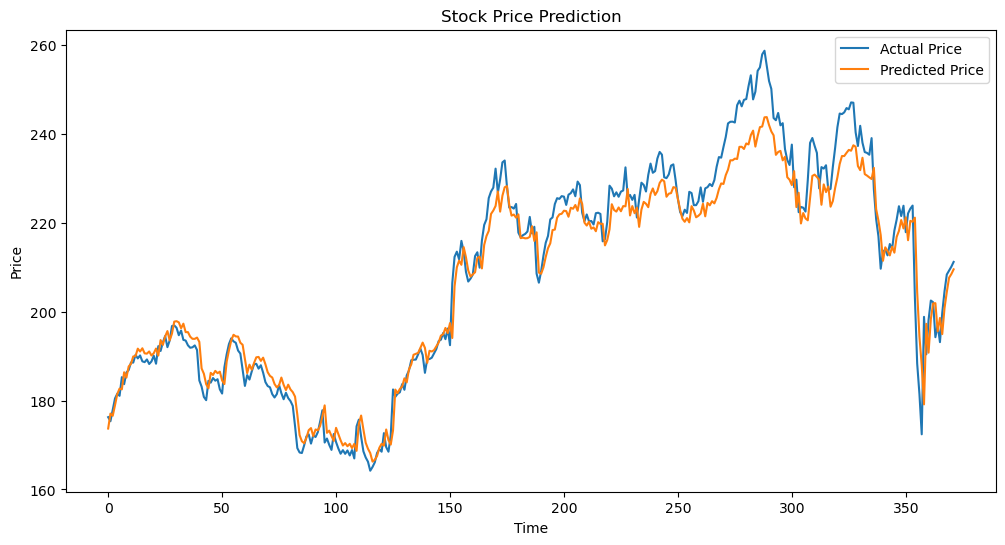

In [38]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

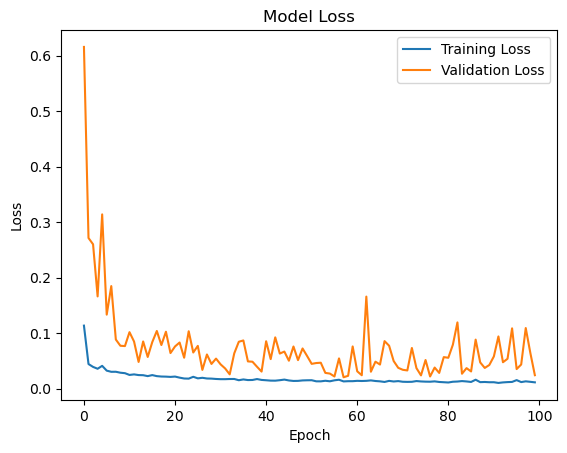

In [40]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Evaluating Forecasting Accuracy
1. Single-Step Test Set Evaluation.
   * After predicting on X_test, I compared predictions vs. actual values using standard regression metrics:

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [45]:
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 5.3120
MAE: 4.0140
R² Score: 0.9534


* RMSE (Root Mean Squared Error): Penalizes larger errors. Lower is better.
* MAE (Mean Absolute Error): Easier to interpret in terms of currency.
* R² Score: Ranges from 0 to 1. Higher means better variance explained by the model.

2. Backtesting Multi-Step Forecast
* Simulate forecasting just like in production — use a sliding window to predict the next 30 days, then compare the predictions with actual values.

In [51]:
forecast_horizon = 30     # How many days ahead to predict
input_window = 100        # Number of past days to use
step_size = 10            # How often to slide the window

In [69]:
backtest_predictions = []
backtest_actuals = []

start = input_window
end = len(scaled_data) - forecast_horizon

for i in range(start, end, step_size):
    # Prepare input for model
    input_seq = scaled_data[i - input_window:i]
    input_seq = input_seq.reshape(1, input_window, 1)

    # Forecast next 30 days
    forecast = []
    current_input = input_seq.copy()

    for _ in range(forecast_horizon):
        pred = model.predict(current_input, verbose=0)[0][0]
        forecast.append(pred)
        new_input = np.append(current_input[0][1:], [[pred]], axis=0)
        current_input = new_input.reshape(1, input_window, 1)

    # Store predictions (inverse scaled) and actuals
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    actual = actual_prices_all[i:i + forecast_horizon]

    if len(actual) == forecast_horizon:
        backtest_predictions.append(forecast)
        backtest_actuals.append(actual)

In [71]:
# Flatten lists
preds = np.concatenate(backtest_predictions)
acts = np.concatenate(backtest_actuals)

# Metrics
rmse_bt = np.sqrt(mean_squared_error(acts, preds))
mae_bt = mean_absolute_error(acts, preds)

print(f"[Backtest] RMSE: {rmse_bt:.4f}")
print(f"[Backtest] MAE: {mae_bt:.4f}")

[Backtest] RMSE: 17.4034
[Backtest] MAE: 13.2101


In [73]:
# Select the first backtest window
predicted_window = backtest_predictions[0].flatten()
actual_window = backtest_actuals[0].flatten()
days = list(range(1, len(predicted_window) + 1))

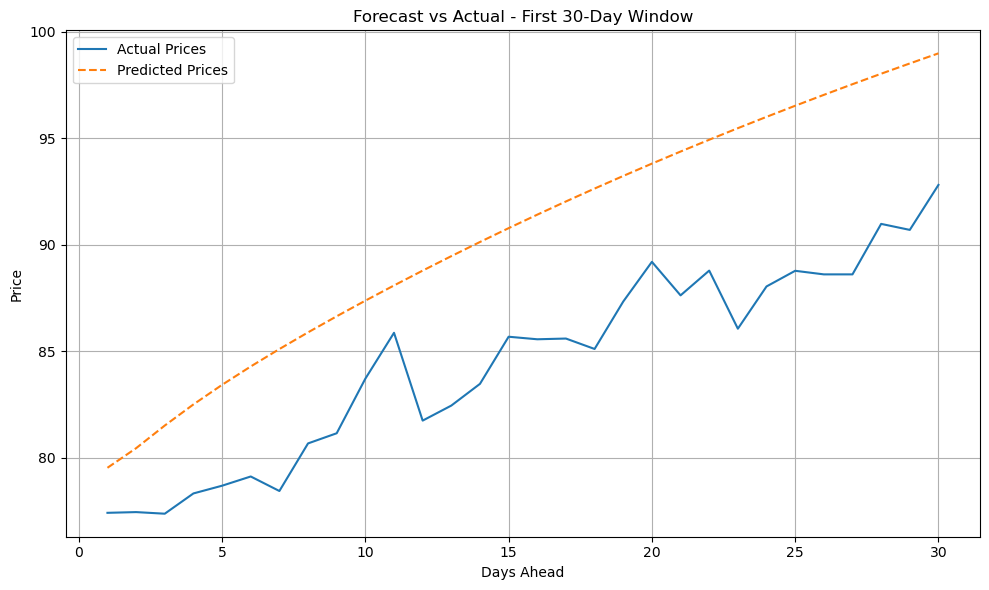

In [75]:
plt.figure(figsize=(10,6))
plt.plot(days, actual_window, label='Actual Prices')
plt.plot(days, predicted_window, label='Predicted Prices', linestyle='--')
plt.title('Forecast vs Actual - First 30-Day Window')
plt.xlabel('Days Ahead')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

### 📊 Evaluation:
- **One-Step Ahead Test Accuracy:**
  - RMSE: 5.31
  - MAE: 4.01
  - R² Score: 0.953
- **Multi-Step Forecasting (Backtesting over rolling windows):**
  - RMSE: 17.40
  - MAE: 13.21

This difference between single-step and multi-step performance reflects the common challenge of error accumulation during sequential predictions — a realistic issue in production time series applications.

Recommendation:
* Use one-step metrics to diagnose training issues (e.g., is the model learning).
* Use backtesting to evaluate real-world forecasting performance.
* If needed, look into techniques like scheduled sampling, teacher forcing, or sequence-to-sequence models to improve multi-step forecasting.


## 5. Predict the Future 30 days and Plot the Output

In [40]:
forecast_days = 30  # Number of future days to predict

# Get the last 100 days from the original scaled data
last_sequence = scaled_data[-100:]
forecast_input = last_sequence.reshape(1, 100, 1)

In [42]:
forecast = []
forecast_input = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)

for _ in range(forecast_days):
    next_price = model.predict(forecast_input)[0][0]  # Predict next value
    forecast.append(next_price)

    # Shift sequence and add new prediction
    new_input = np.append(forecast_input[0][1:], [[next_price]], axis=0)
    forecast_input = new_input.reshape(1, sequence_length, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

In [44]:
# Convert back to actual prices
forecast_prices = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

In [48]:
historical_prices = df[['Date', 'Close']].iloc[-100:]

In [50]:
last_date = historical_prices['Date'].iloc[-1]
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, forecast_days + 1)]

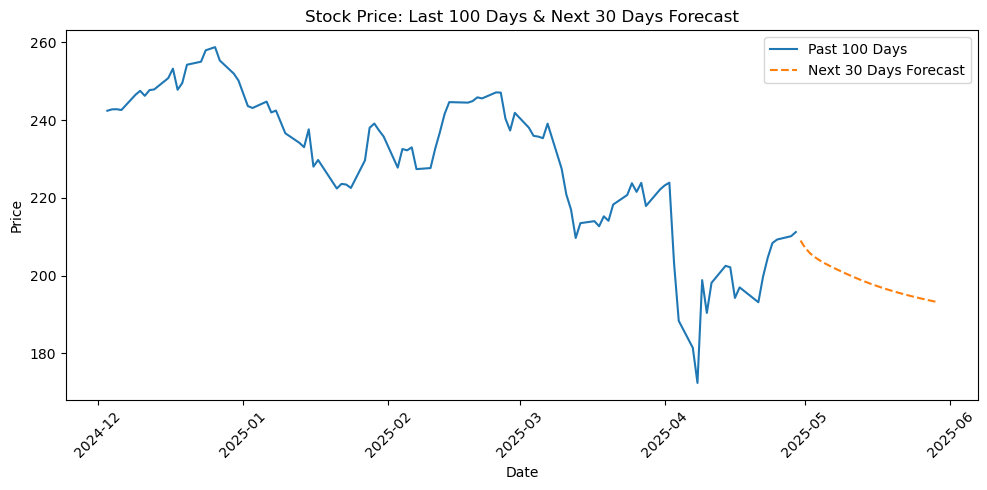

In [52]:
plt.figure(figsize=(10,5))

# Plot past 100 days
plt.plot(historical_prices['Date'], historical_prices['Close'], label='Past 100 Days')

# Plot forecast
plt.plot(forecast_dates, forecast_prices, label='Next 30 Days Forecast', linestyle='--')

plt.title('Stock Price: Last 100 Days & Next 30 Days Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

In [150]:
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close': forecast_prices.flatten()
})

In [152]:
#forecast_df.to_csv('forecast_30_days.csv', index=False)

### 🔍 Insights:
- The LSTM model was effective in capturing trends and short-term patterns.
- Recursive forecasting works, but performance degrades over longer horizons.
- Backtesting provided a more accurate assessment of real-world performance.

### 🛠️ Potential Improvements:
- Include more features such as volume, moving averages, or technical indicators.
- Experiment with more advanced models like Transformer-based architectures.
- Try direct multi-step forecasting (predict all 30 days at once) instead of recursive.
- Integrate external factors (e.g., news sentiment or macroeconomic indicators).

### 🧠 Final Thought:
This project demonstrates my ability to handle real-world time series forecasting tasks with deep learning, while carefully balancing model performance and evaluation integrity.